# 0. Imports

In [107]:

from functools import partial
import os
from pathlib import Path

from IPython.display import HTML
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy import stats
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.gridspec as gridspec
import numpy as np
from tqdm import tqdm
from time import time
import optax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from scipy.stats import norm
from sklearn.metrics import mean_squared_error

from demos.showdown.classification import classification_train as benchmark
from demos.showdown.regression.peter import hparam_tune_reg as hpt
from rebayes.datasets import classification_data as data_utils
from rebayes.datasets import rotating_permuted_mnist_data as rmnist_data

In [2]:
%load_ext autoreload
%autoreload 2

In [84]:
# Initialize model
mlp_init_fn = lambda key: \
    benchmark.init_model(type='mlp', features=(100, 100, 1), key=key, rescale=False)
model_dict = mlp_init_fn(0)

# 1. Nonstationary RMNIST (IID angle)

In [150]:
ntrain_per_task, ntest_per_task = 300, 200

dataset = rmnist_data.load_discrete_task_rotating_mnist_dataset(ntrain_per_task, ntest_per_task)

In [151]:
# Select 10 random images (different digits) from the test set
test_idx = jnp.arange(ntest_per_task//3, 10*ntest_per_task, ntest_per_task)
Xte, yte = dataset['test']
test_nst_images, test_nst_labels = Xte[test_idx], yte[test_idx]

# Introduce an MNIST image as an OOD sample
dataset_ood = data_utils.load_mnist_dataset(fashion=True) # load data
X_ood_test, y_ood_test = dataset_ood['test']
del dataset_ood

ood_idx = jr.choice(jr.PRNGKey(0), X_ood_test.shape[0])
ood_nst_img, ood_nst_label = X_ood_test[ood_idx], 0.0

In [152]:
all_test_nst_images = jnp.concatenate([test_nst_images, ood_nst_img[None, ...]], axis=0)
all_test_nst_labels = jnp.concatenate([test_nst_labels, jnp.array([ood_nst_label])], axis=0)

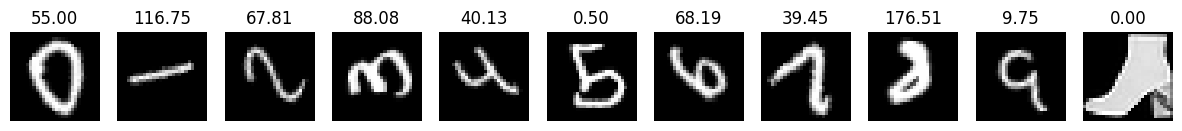

In [153]:
# Plot the images
fig, axs = plt.subplots(1, 11, figsize=(15, 1.5))
for i in range(11):
    axs[i].imshow(all_test_nst_images[i, ..., 0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'{all_test_nst_labels[i]:.2f}');

In [192]:
def final_window_callback(bel, loss_fn, nan_val=-1e8, window_size=100, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    X_test, y_test = X_test[-window_size:], y_test[-window_size:]

    eval = -benchmark.evaluate_function(bel.mean, apply_fn, X_test, y_test, loss_fn)
    if isinstance(eval, dict):
        eval = {k: jnp.where(jnp.isnan(v), nan_val, v) for k, v in eval.items()}
    else:
        eval = jnp.where(jnp.isnan(eval), nan_val, eval)
    
    return eval

def rmse_loss(pred, y):
    return jnp.sqrt(jnp.mean((pred - y)**2))

emission_cov = 10**2
log_emission_cov = jnp.log(emission_cov)

final_window_rmse_callback = partial(final_window_callback, loss_fn=rmse_loss,)
nll_function = lambda pred, y: -tfd.Normal(loc=pred, scale=jnp.sqrt(emission_cov)).log_prob(y)
final_window_ll_callback = partial(final_window_callback, loss_fn=nll_function,)

## 1.1 LOFI-10

In [193]:
lofi_10_diag_agent = {
    'memory_size': 10,
    'inflation': "hybrid",
    "lofi_method": "diagonal",
}

lofi_pbounds={
    'log_init_cov': (-20, 1.0),
    'log_dynamics_weights': (-20, 0.0),
    'log_dynamics_cov': (-20, 5.0),
    'log_emission_cov': (log_emission_cov, log_emission_cov),
    'log_alpha': (-90, -90),
}

In [194]:
optimizer = hpt.create_optimizer(
    mlp_init_fn, lofi_pbounds, dataset['train'], dataset['test'], 
    callback=final_window_rmse_callback, method="lofi", verbose=2, 
    callback_at_end=True, warmup_steps=0, cooldown_steps=0, **lofi_10_diag_agent
)
optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------------------
| 1         | -78.61    | -90.0     | -2.12     | -7.945    | 4.605     | -11.1     |
| 2         | -93.32    | -90.0     | -9.06     | -2.165    | 4.605     | -11.95    |
| 3         | -81.92    | -90.0     | -6.778    | -8.639    | 4.605     | -18.51    |
| 4         | -93.32    | -90.0     | -19.49    | -3.348    | 4.605     | -1.73     |
| 5         | -61.64    | -90.0     | -0.02104  | -10.77    | 4.605     | -17.52    |
| 6         | -93.32    | -90.0     | -16.42    | -1.107    | 4.605     | -11.29    |
| 7         | -66.1     | -90.0     | -0.6442   | -10.88    | 4.605     | -19.61    |
| 8         | -82.1     | -90.0     | -4.698    | -7.661    | 4.605     | -5.682    |
| 9         | -89.77    | -90.0     | -9.074    | -6.047    | 4.605     | -5.998    |
| 10        | -89.72    | -90.0     | -14.74    | -17.

In [184]:
# best_hparams = hpt.get_best_params(optimizer, method="lofi")
# best_hparams
best_hparams = {
    'initial_covariance': 0.6036908626556396,
    'dynamics_covariance': 1.0,
    'dynamics_covariance_inflation_factor': 0.0,
    'dynamics_weights': 0.9999999888402824,
    'emission_cov_function': lambda w, x: np.exp(log_emission_cov),
}

In [185]:
estimator, init_cov = hpt.build_estimator(
    mlp_init_fn,
    best_hparams,
    method="lofi",
    **lofi_10_diag_agent,
)

In [186]:
# Train
def map_callback(bel, *args, **kwargs):
    test_imgs = kwargs['test_imgs']
    def compute_preds(img):
        preds = model_dict["apply_fn"](bel.mean, img.reshape(1, 28, 28, 1))
        
        return preds
    
    preds = jax.vmap(compute_preds)(test_imgs)
    
    return preds

test_kwargs = {
    "test_imgs": all_test_nst_images
}

_, outputs = estimator.scan(model_dict["flat_params"], init_cov, *dataset["train"], 
                                map_callback, **test_kwargs)

In [187]:
# X, y = dataset["train"]
# plt.imshow(X[1050].reshape(28, 28), cmap='gray');

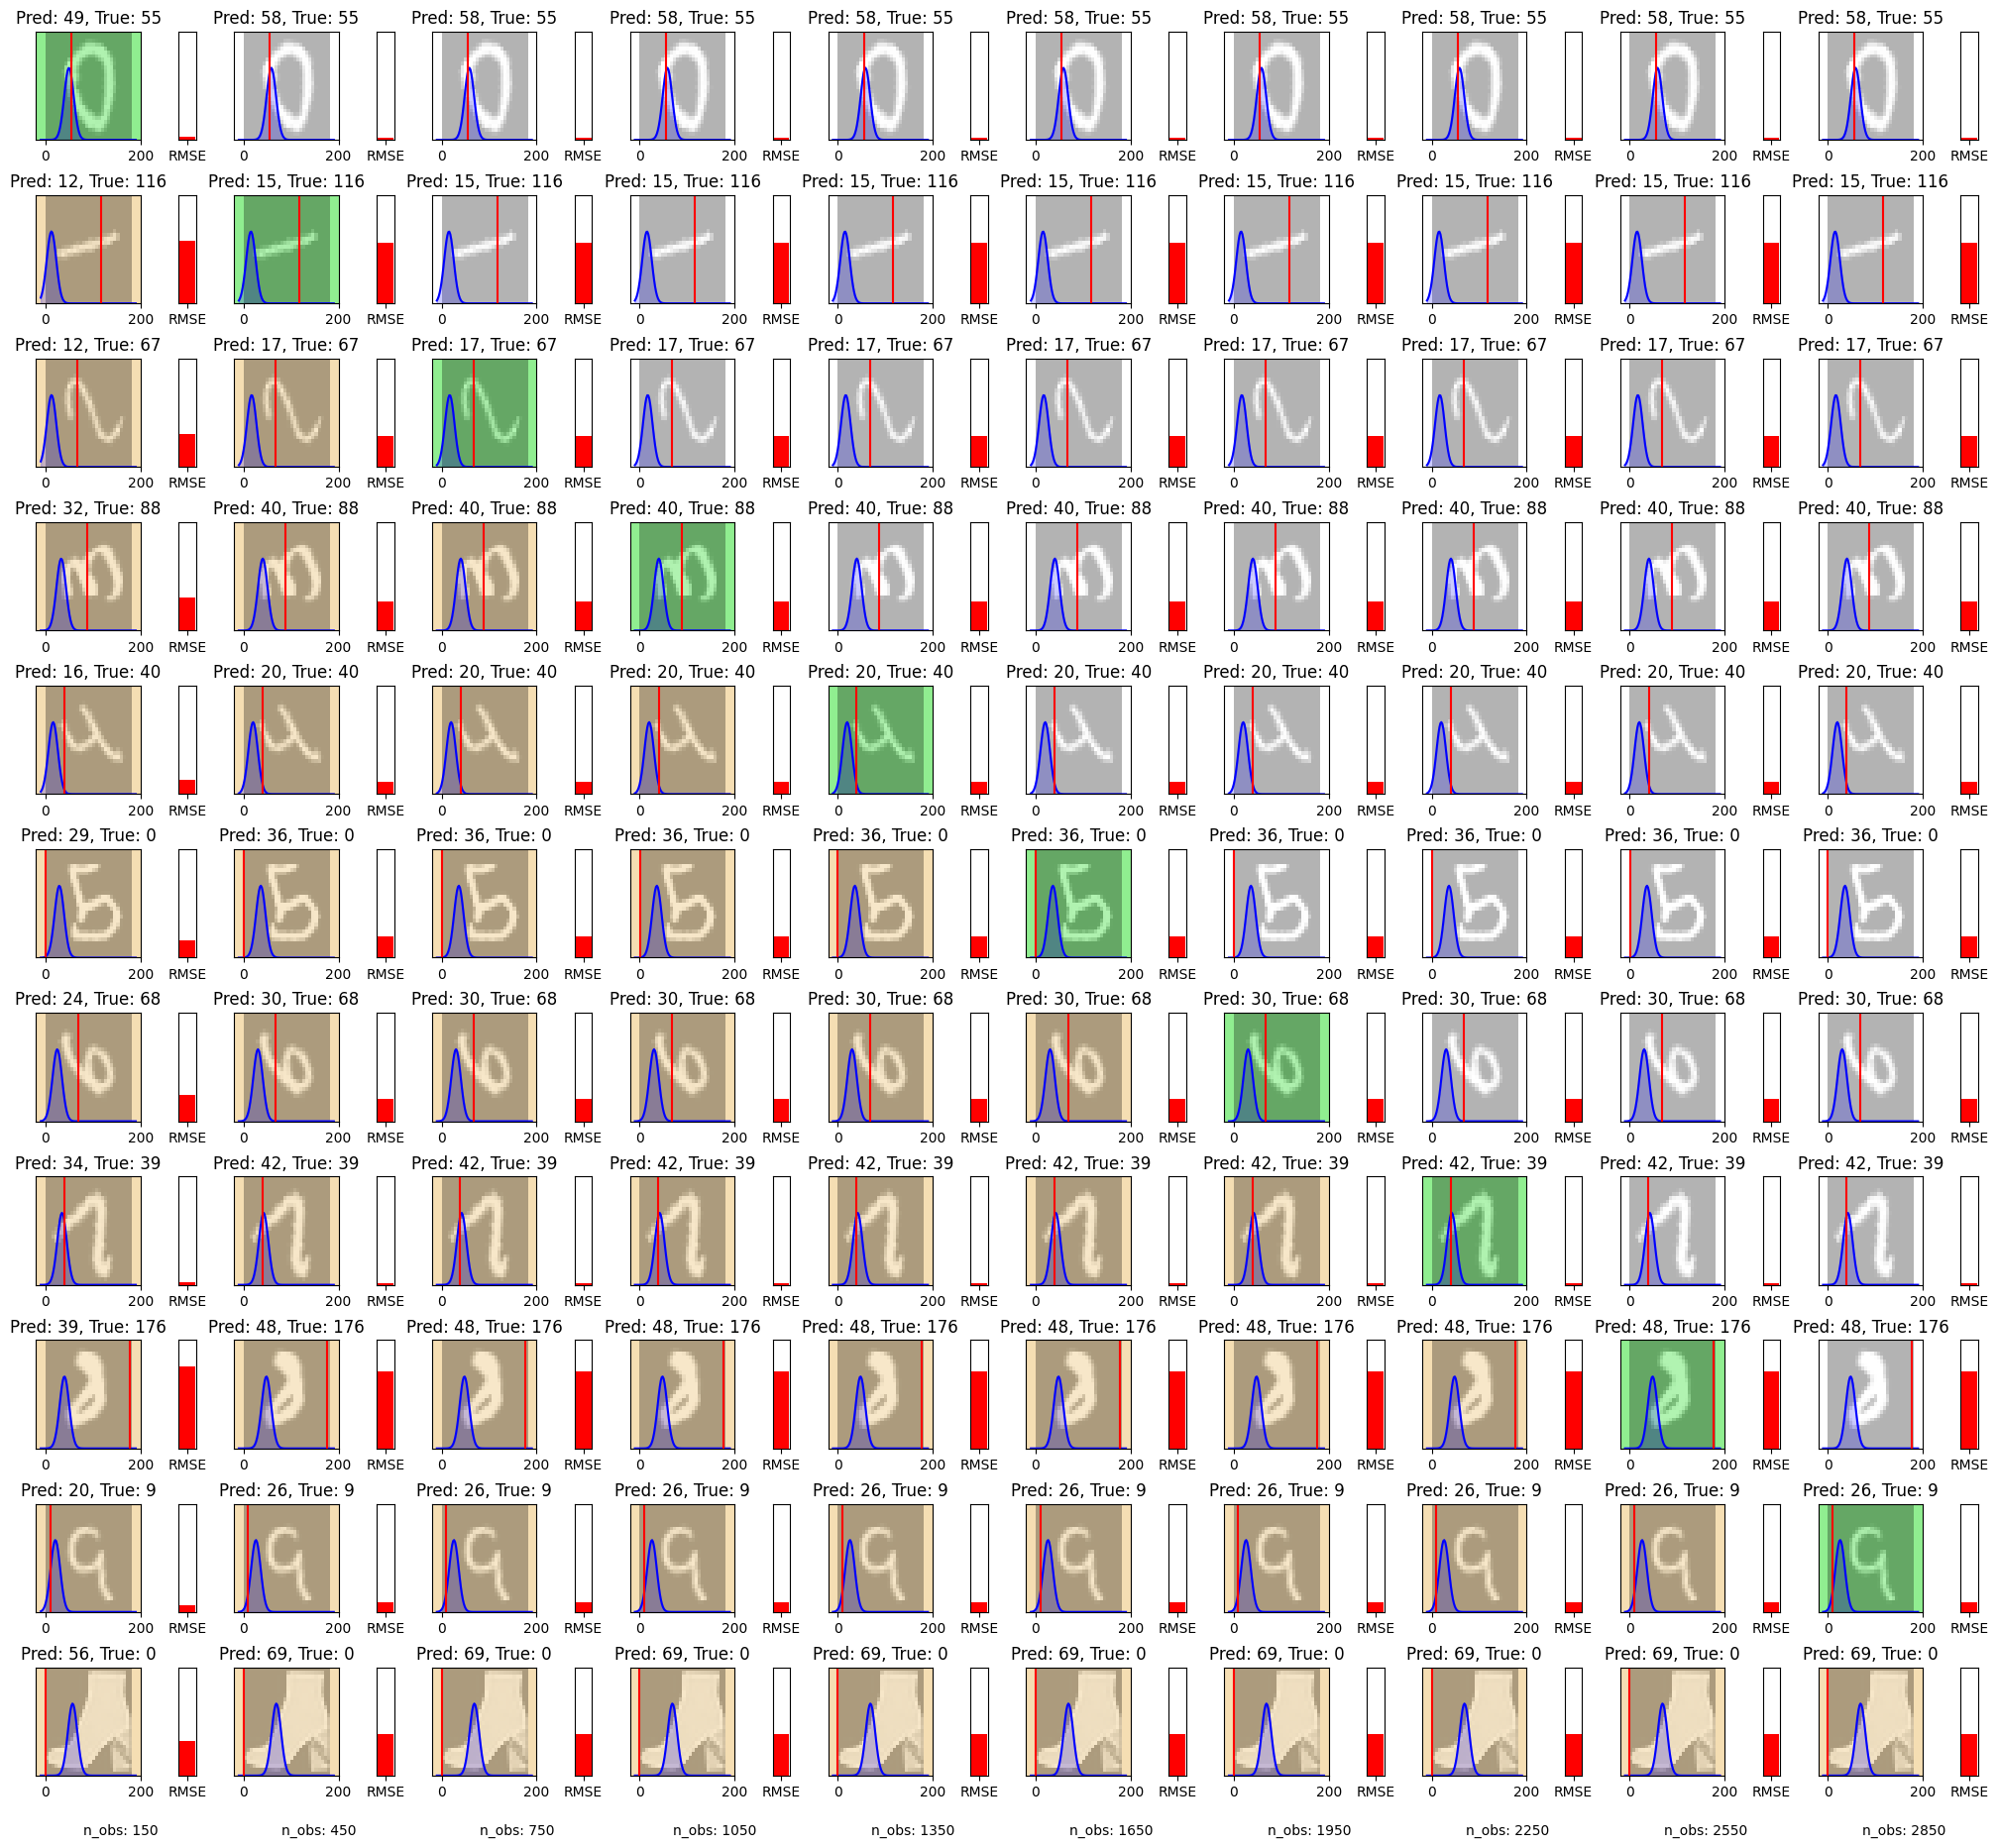

In [189]:
# 11x10 grid
N = len(outputs)
frames = jnp.arange(150, N, N // 10)
n_test_images = 11


fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(n_test_images, len(frames)*2, width_ratios=[6, 1]*len(frames))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_nst_images[j]
        ax = plt.subplot(gs[j, 2*i])
        ax.imshow(curr_img, cmap='gray', extent=[0, 180, 0, 0.06], aspect='auto', alpha=0.3)
        ax.set_ylim(0, 0.06)
        ax.set_yticks([])

        pred = outputs[frame, j].item()
        true_value = all_test_nst_labels[j]
        
        x_values = np.linspace(-10.0, 190.0, 100)
        y_values = norm.pdf(x_values, pred, np.sqrt(emission_cov))
        
        ax.plot(x_values, y_values, color='blue')
        ax.fill_between(x_values, y_values, color='blue', alpha=0.2)
        ax.axvline(x=true_value, color='red')
        
        if i == j:
            ax.set_facecolor('lightgreen')
        elif i < j:
            ax.set_facecolor('wheat')

        rmse = np.sqrt(mean_squared_error([true_value], [pred]))
        ax2 = plt.subplot(gs[j, 2*i+1])
        ax2.bar(1, rmse, color='red')  # x-coordinate is arbitrary as we only have one bar
        ax2.set_ylim(0, 180.0)  # assuming RMSE is also in this range
        ax2.set_xticks([1])  # set tick position
        ax2.set_xticklabels(['RMSE'])  # set tick label
        ax2.set_yticks([])  # remove y-axis
        
        ax.set_title(f"Pred: {int(pred)}, True: {int(true_value)}")

    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()
